# Data only contains accelerometer data

# Data Loading and preprocessing


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [ ]:
data_frames= []

In [ ]:
from sklearn.utils import shuffle

csv_files = ['FlyX.csv', 'BackX.csv', 'BreastX.csv', 'FreeX.csv']


# Load each file
for file in csv_files:
    df = pd.read_csv(file)
    data_frames.append(df)

# Concatenate all the data frames
combined_df = pd.concat(data_frames, ignore_index=True)

# applying scaler to normalize
scaler = StandardScaler()
features = ['x', 'y', 'z']

combined_df[features] = scaler.fit_transform(combined_df[features])

#shuffling data
combined_df = shuffle(combined_df, random_state=42)



#double check
print(combined_df.head(-1))

       Time (seconds)         x         y         z  stroke
17925          192.34  0.414440 -0.236123  0.149372       2
4845           299.59  0.504042  0.567691 -1.178611       3
7325           350.93  0.373381 -0.001899  0.393540       0
7581           361.97  0.364607 -0.007441  0.389010       0
17031          153.66  0.430811 -0.216646  0.150673       2
...               ...       ...       ...       ...     ...
21575          301.34  0.360161 -0.005128  0.388462       0
29802          324.23 -0.115604  3.468772 -0.270539       4
5390           323.07 -1.228150  0.795724 -0.490327       3
860            192.80 -0.707084  0.073621 -0.993526       1
15795          172.93  0.523758 -0.048472  0.265411       1

[30791 rows x 5 columns]


0


# Preparing the Model

**LSTM/ CNN**

In [ ]:
# Encoding labels

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encoding labels
encoder = LabelEncoder()
combined_df['stroke'] = encoder.fit_transform(combined_df['stroke'])

# Convert the integer-encoded labels into one-hot encoding format

labels = to_categorical(combined_df['stroke'].values)



In [ ]:
import numpy as np

sequence_length = 50  #initally picked at random

# Define a function to create sequences from the data

def create_sequences(data, labels, sequence_length):
    X, y = [], []
    # Iterate through the data to create sequences of the specified length

    for i in range(len(data) - sequence_length + 1):
        # Append a new sequence of data from position i to i + sequence_length to X
        X.append(data[i:(i + sequence_length)])

        # Append the label corresponding to the end of the sequence to y
        y.append(labels[i + sequence_length - 1])
    return np.array(X), np.array(y)

# Extract the feature data as a numpy array from the combined dataframe

data = combined_df[features].values

# Use the create_sequences function to generate sequences and their corresponding labels from the data

X, y = create_sequences(data, labels, sequence_length)


In [ ]:
from sklearn.model_selection import train_test_split

#splitting up training/testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential()

# Add the first LSTM layer with 50 units.

model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add the second LSTM layer with 50 units.

model_lstm.add(LSTM(units=50))

#Add a fully connected layer that will output the predicted probabilities.
# The number of units equals the number of categories, using a softmax activation function
model_lstm.add(Dense(units=y_train.shape[1], activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#training the model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/10
692/692 [==============================] - 48s 63ms/step - loss: 1.0938 - accuracy: 0.5361 - val_loss: 0.8302 - val_accuracy: 0.6516
Epoch 2/10
692/692 [==============================] - 44s 64ms/step - loss: 0.7134 - accuracy: 0.6973 - val_loss: 0.6142 - val_accuracy: 0.7451
Epoch 3/10
692/692 [==============================] - 45s 66ms/step - loss: 0.5828 - accuracy: 0.7695 - val_loss: 0.5390 - val_accuracy: 0.7882
Epoch 4/10
692/692 [==============================] - 45s 65ms/step - loss: 0.5261 - accuracy: 0.7993 - val_loss: 0.5021 - val_accuracy: 0.7943
Epoch 5/10
692/692 [==============================] - 55s 80ms/step - loss: 0.4883 - accuracy: 0.8097 - val_loss: 0.4801 - val_accuracy: 0.8033
Epoch 6/10
692/692 [==============================] - 45s 65ms/step - loss: 0.4605 - accuracy: 0.8175 - val_loss: 0.4476 - val_accuracy: 0.8167
Epoch 7/10
692/692 [==============================] - 44s 63ms/step - loss: 0.4428 - accuracy: 0.8250 - val_loss: 0.4351 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generate predictions for the test set
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
report = classification_report(y_test_classes, y_pred_classes)
print(report)


193/193 [==============================] - 4s 19ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       877
           1       0.74      0.49      0.59      1293
           2       0.98      0.92      0.95      1710
           3       0.70      0.92      0.80      1946
           4       0.83      0.67      0.74       323

    accuracy                           0.83      6149
   macro avg       0.85      0.80      0.82      6149
weighted avg       0.84      0.83      0.82      6149



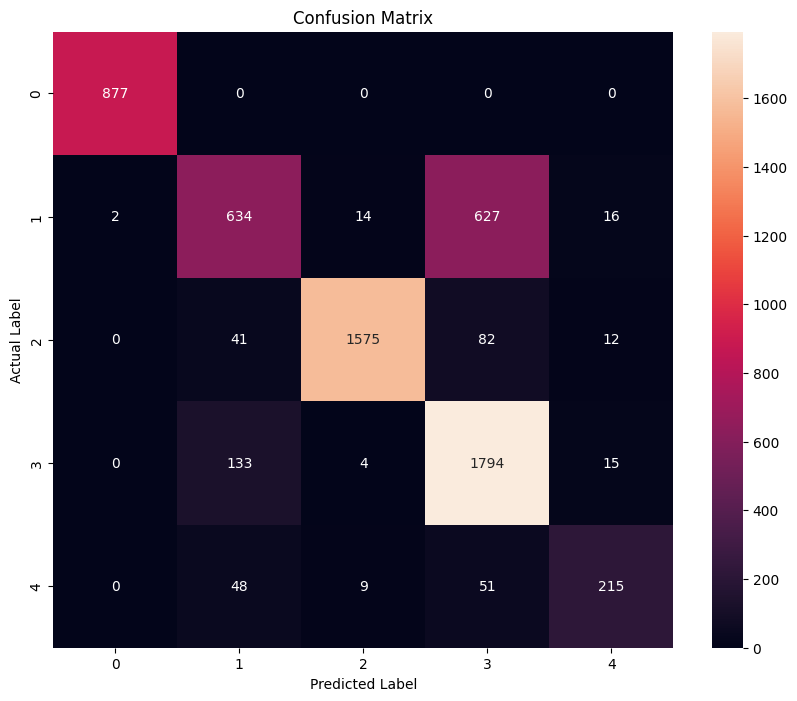

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


**CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model_cnn = Sequential()

# Add a 1D Convolutional layer to process sequences

model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a Max Pooling layer to reduce the dimensionality of the sequence data
model_cnn.add(MaxPooling1D(pool_size=2))

# Flatten the output of the pooling layer
model_cnn.add(Flatten())

# Add a fully connected  layer for classification with relu
model_cnn.add(Dense(50, activation='relu'))

#add in output layer
model_cnn.add(Dense(y_train.shape[1], activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)




Epoch 1/10
692/692 [==============================] - 7s 8ms/step - loss: 1.3023 - accuracy: 0.4500 - val_loss: 1.1621 - val_accuracy: 0.4992
Epoch 2/10
692/692 [==============================] - 4s 5ms/step - loss: 1.0885 - accuracy: 0.5375 - val_loss: 1.0425 - val_accuracy: 0.5492
Epoch 3/10
692/692 [==============================] - 4s 5ms/step - loss: 1.0129 - accuracy: 0.5743 - val_loss: 1.0155 - val_accuracy: 0.5598
Epoch 4/10
692/692 [==============================] - 5s 7ms/step - loss: 0.9694 - accuracy: 0.5956 - val_loss: 0.9711 - val_accuracy: 0.5813
Epoch 5/10
692/692 [==============================] - 4s 6ms/step - loss: 0.9340 - accuracy: 0.6139 - val_loss: 0.9711 - val_accuracy: 0.5846
Epoch 6/10
692/692 [==============================] - 4s 6ms/step - loss: 0.9087 - accuracy: 0.6218 - val_loss: 0.9737 - val_accuracy: 0.5988
Epoch 7/10
692/692 [==============================] - 5s 7ms/step - loss: 0.8779 - accuracy: 0.6381 - val_loss: 0.9210 - val_accuracy: 0.6203
Epoch 

In [ ]:
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

193/193 [==============================] - 2s 9ms/step - loss: 0.8875 - accuracy: 0.6339
Test Loss: 0.887535572052002
Test Accuracy: 0.6339241862297058


In [ ]:
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
report = classification_report(y_test_classes, y_pred_classes)
print(report)

193/193 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.56      0.74      0.64       877
           1       0.49      0.45      0.47      1293
           2       0.77      0.76      0.77      1710
           3       0.64      0.62      0.63      1946
           4       0.69      0.45      0.54       323

    accuracy                           0.63      6149
   macro avg       0.63      0.61      0.61      6149
weighted avg       0.64      0.63      0.63      6149



CNN- Adding in 3 hidden layers with dropout

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model_cnn = Sequential()
# First Convolutional Layer
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.2))  # Dropout layer for regularization

# Second Convolutional Layer
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.2))  # Another Dropout layer

# Third Convolutional Layer
model_cnn.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.2))  # Another Dropout layer

model_cnn.add(Flatten())  # Flatten the output to feed into the Dense layer

# fullly connected Layer
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.5))  # Dropout layer before the output layer

# Output Layer
model_cnn.add(Dense(y_train.shape[1], activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
692/692 [==============================] - 16s 19ms/step - loss: 1.5080 - accuracy: 0.2912 - val_loss: 1.4921 - val_accuracy: 0.3146
Epoch 2/10
692/692 [==============================] - 13s 19ms/step - loss: 1.4939 - accuracy: 0.3018 - val_loss: 1.4842 - val_accuracy: 0.3146
Epoch 3/10
692/692 [==============================] - 14s 20ms/step - loss: 1.4910 - accuracy: 0.3063 - val_loss: 1.4859 - val_accuracy: 0.3146
Epoch 4/10
692/692 [==============================] - 13s 18ms/step - loss: 1.4897 - accuracy: 0.3062 - val_loss: 1.4863 - val_accuracy: 0.3146
Epoch 5/10
692/692 [==============================] - 13s 18ms/step - loss: 1.4889 - accuracy: 0.3064 - val_loss: 1.4843 - val_accuracy: 0.3146
Epoch 6/10
692/692 [==============================] - 13s 18ms/step - loss: 1.4878 - accuracy: 0.3058 - val_loss: 1.4845 - val_accuracy: 0.3146
Epoch 7/10
692/692 [==============================] - 13s 18ms/step - loss: 1.4869 - accuracy: 0.3070 - val_loss: 1.4831 - val_accuracy:

In [ ]:
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

193/193 [==============================] - 2s 10ms/step - loss: 1.4819 - accuracy: 0.3165
Test Loss: 1.4819401502609253
Test Accuracy: 0.31647422909736633


**DTW**

In [ ]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score

In [ ]:
csv_files = ['FlyX.csv', 'BackX.csv', 'BreastX.csv', 'FreeX.csv']

data_frames= []
# Load each file
for file in csv_files:
    df = pd.read_csv(file)
    data_frames.append(df)

# Concatenate all the data frames
combined_df = pd.concat(data_frames, ignore_index=True)

# applying scaler to normalize
scaler = StandardScaler()
features = ['x', 'y', 'z']

combined_df[features] = scaler.fit_transform(combined_df[features])




In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encoding labels
encoder = LabelEncoder()
combined_df['stroke'] = encoder.fit_transform(combined_df['stroke'])

# Formatting for DTW
time_series = to_time_series_dataset(combined_df[['x', 'y', 'z']].values.reshape(-1, 1, 3))
labels = combined_df['stroke'].values

In [ ]:
#splitting up data
X_train, X_test, y_train, y_test = train_test_split(time_series, labels, test_size=0.2, random_state=42)


In [ ]:
# Train a k-NN classifier with DTW
model_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
model_dtw.fit(X_train, y_train)

# Predict and evaluate accuracy
y_pred = model_dtw.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"DTW Classification Accuracy: {accuracy}")


DTW Classification Accuracy: 0.7844155844155845
